# Time Series Analysis

To access this data, you will need to get an API key from the EIA website found [here](https://www.eia.gov/opendata/register.php)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import urllib
from statsmodels.api import tsa # main time series analysis package in python

In [51]:
# Let's download Texas hourly electricity demand data from the US Government's EIA website

# key='2491958b207e0e1442b709e26491bca1'
# url = f'http://api.eia.gov/series/?api_key={key}&series_id=EBA.TEX-ALL.D.HL'
# r = requests.get(url)

# df = pd.DataFrame(r.json()['series'][0]['data'])
# df.to_csv('tx_hourly_elec_demand.csv', index=False)
df = pd.read_csv('tx_hourly_elec_demand.csv')
df.columns = ['date','megawatthours']
df.date = pd.to_datetime(df.date, utc=True)
df = df.set_index('date')

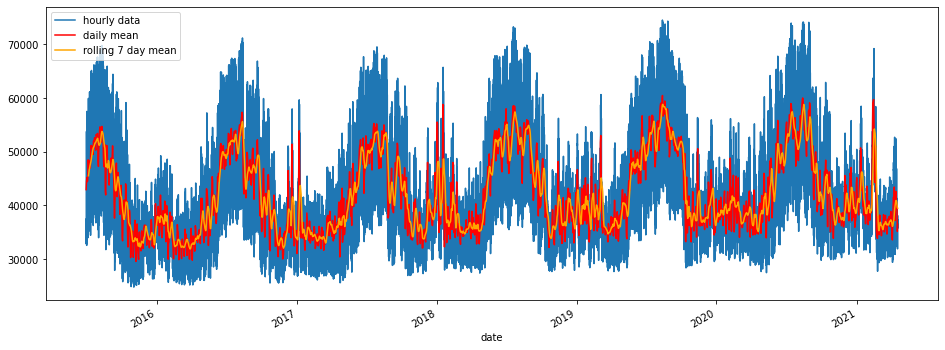

In [52]:
fig, ax = plt.subplots(1,1, figsize=(16,6))

df.megawatthours.plot(ax=ax, label='hourly data')
df.megawatthours.resample('D').mean().plot(ax=ax, color='r', label='daily mean')
df.megawatthours.resample('D').mean().rolling(7).mean().plot(ax=ax, color='orange', label='rolling 7 day mean')
ax.legend()

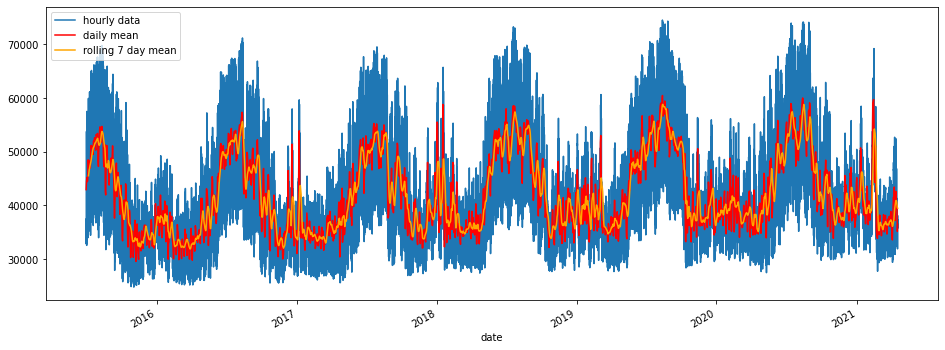

In [53]:
fig, ax = plt.subplots(1,1, figsize=(16,6))

df.megawatthours.plot(ax=ax, label='hourly data')
df.megawatthours.resample('D').mean().plot(ax=ax, color='r', label='daily mean')
df.megawatthours.resample('D').mean().rolling(7).mean().plot(ax=ax, color='orange', label='rolling 7 day mean')
ax.legend()

In [56]:
df

megawatthours
date                                    
2021-04-18 04:00:00+00:00          35909
2021-04-18 03:00:00+00:00          36850
2021-04-18 02:00:00+00:00          37318
2021-04-18 01:00:00+00:00          36468
2021-04-18 00:00:00+00:00          35910
...                                  ...
2015-07-01 10:00:00+00:00          32805
2015-07-01 09:00:00+00:00          32798
2015-07-01 08:00:00+00:00          33638
2015-07-01 07:00:00+00:00          35119
2015-07-01 06:00:00+00:00          37456

[50759 rows x 1 columns]

In [54]:
df.megawatthours.corr(df.megawatthours.shift())

0.982097271607208

In [71]:
#######################################
# To Load Raw Data from NOAA
# Takes a while...
#######################################

url = 'https://www.ncei.noaa.gov/access/services/data/v1'
st = pd.read_csv('noaa_stations2.csv')

st_list = st.STATION.to_list()

tt = pd.DataFrame()
for s in st_list:

    params = urllib.parse.urlencode(dict(
        dataset='daily-summaries',
        stations=s,
        startDate='2015-01-01',
        endDate='2021-04-15',
        format='json',
        includeStationName='false',
        units='metric',
        includeStationLocation='false'
    ))

    r = requests.get(url, params=params)

    tt = tt.append(pd.DataFrame(r.json()))

tt.to_pickle('tx_temp_raw.pkl')

In [72]:
######################################
# Transform Raw Temp Date to daily Mean
######################################

tt = pd.read_pickle('tx_temp_raw.pkl')

tt = tt[['DATE','STATION','TMAX','TMIN']].dropna()

tt.DATE = pd.to_datetime(tt.DATE)

tt.TMAX = pd.to_numeric(tt.TMAX)
tt.TMIN = pd.to_numeric(tt.TMIN)

tt = tt.merge(st, on='STATION')

tt['TEMP'] = (tt.TMAX + tt.TMIN)/2

tt.to_pickle('tx_temp.pkl')

In [74]:
tt = pd.read_pickle('tx_temp.pkl')

In [75]:
mtemp = tt.set_index(['NAME','DATE']).TEMP.unstack(level=0).loc['2015-01-01':,:].mean(axis=1)

In [76]:
mtemp

DATE
2015-01-01    -1.115361
2015-01-02     1.300882
2015-01-03     3.630060
2015-01-04     3.531176
2015-01-05     2.066667
                ...    
2021-04-11    17.349112
2021-04-12    20.275575
2021-04-13    19.333807
2021-04-14    18.563966
2021-04-15    16.883333
Length: 2297, dtype: float64

# Resources

https://www.aptech.com/blog/introduction-to-the-fundamentals-of-time-series-data-and-analysis/

https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm

https://www.ncei.noaa.gov/access